# 13 - Projections
- 13.1 Projections in $\mathbb{R}^2$
- 13.2 Projections in $\mathbb{R}^N$
- 13.3 Orthogonal and parallel vector components
- 13.4 Orthogonal matrices
- 13.5 Orthogonalization via Gram-Schmidt
- 13.6 QR decomposition
- 13.7 Inverse via QR
- 13.8 Exercises
- 13.9 Answers
- 13.10 Coding challenges
- 13.11 Code solutions

Notes, code snippets, and the end of chapter exercises from the book _Linear Algebra: Theory, Intuition, Code_ by Mike X Cohen. 

Find more information about the book on [github](https://github.com/mikexcohen/LinAlgBook) and [amazon](https://www.amazon.com/Linear-Algebra-Theory-Intuition-Code/dp/9083136604).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## 13.1 Projections in $\mathbb{R}^2$
Projection performs a transformation from one space onto another.

In the diagram below, the point $b$ is orthogonally projected onto the line $a$ such that the orthogonal projection from $b$ to $a$ meets at the point $\beta$.
- The vector $b - \beta a$ is orthogonal to $a$.

### Deriving $\beta$
The scalar $\beta$ describes how far along $a$ the orthogonal projection lies. Use $a \perp b - \beta a$ to derive.

$$
\begin{align}
a^T (b - \beta a) &= 0 \\
a^T b - \beta a^T a &= 0 \\
\beta a^T a &= a^T b \\
\beta &= \frac{a^T b}{a^T a} \\
\end{align}
$$


### Projection of Plane Onto Line
Project the point $b$ onto the line $a$. 

$$
\text{proj}_a(b) = \frac{a^T b}{a^T a} a = \beta a
$$

### Mapping Over Magnitude
Projection is part of the more general class of transformations described as mapping over magnitude.

```
              mapping
projection = --------- X target
             magnitude
```

- mapping refers to $a^T b$
- magnitude refers to $a^T a$ (_norm squared_)
- target refers to $a$
- other transformations like this include normalization, correlation, and convolution

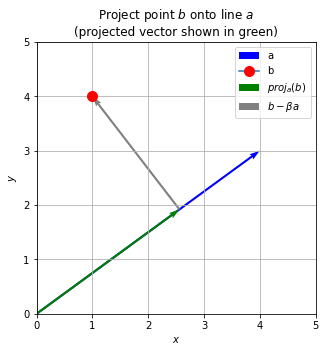

In [2]:
# Example: project point b onto line a.
a = np.array([4, 3])
b = np.array([1, 4])
beta = np.dot(a.T, b) / np.dot(a.T, a)
aTbeta = b - beta * a
projb = np.dot(a.T, b) / np.dot(a.T, a) * a

origin = np.array([0, 0])
plt.figure(figsize=(5,5))
plt.quiver(*origin, *a, angles='xy', scale_units='xy', scale=1, color='blue', label='a')
plt.plot(b[0], b[1], marker='o', markersize=10, markeredgecolor='red', markerfacecolor='red', label='b')
plt.quiver(*origin, *projb, angles='xy', scale_units='xy', scale=1, color='green', label='$proj_a(b)$')
plt.quiver(*projb, *aTbeta, angles='xy', scale_units='xy', scale=1, color='gray', label='$b - \\beta a$')
plt.axis([0,5,0,5])
plt.title('Project point $b$ onto line $a$\n(projected vector shown in green)')
plt.ylabel('$y$')
plt.xlabel('$x$')
plt.legend()
plt.grid()
plt.show()

## 13.2 Projections in $\mathbb{R}^N$
In higher dimensions replace everything you know about target vector $a$ in $\mathbb{R}^2$ with the matrix $A$ in $\mathbb{R}^N$.

### Deriving $x$
Replace the scalar $\beta$ with $x$: this describes the orthogonal projection of the vector $b$ onto the column space of the matrix $A$.

$$
\begin{align}
A^T (b - Ax) &= 0 \\
A^T b - A^T A x &= 0 \\
A^T A x &= A^T b \\
(A^T A)^{-1} A^T A x &= (A^T A)^{-1} A^T b \\
x &= (A^T A)^{-1} A^T b \\
\end{align}
$$

- Observe that $x$ is equal to the is the left inverse $(A^T A)^{-1} A^T$ for tall matrices.

### Projecting $b$ onto $A$
The product of the target matrix $A$ and the vector $x$ describes the orthogonal projection of $b$ into the column space of $A$.
- The residual vector $r = b - Ax$ is equivalent to $b - \beta a$ in $\mathbb{R}^2$, in other words $r \perp Ax$.
- If $b$ is already in the column space of $A$, then no projection required and instead $x$ is an _exact_ solution.

### `numpy solve` vs. `numpy lstsq`
- `numpy.linalg.solve`
    - Computes _exact_ solution of full rank _square_ matrix.
- `numpy.linalg.lstsq`
    - Computes _approximate_ solution of overdetermined system of equations using left inverse.
    - If matrix is full rank and square, then it returns the _exact_ solution.

In [3]:
# Demonstrate the np.linalg.solve and np.linalg.lstsq return same result for full rank square matrix.
m, n = 4, 4
A = np.random.random((m, n))
x = np.random.random(n)
b = A @ x

xhat1 = np.linalg.solve(A, b)
np.testing.assert_almost_equal(xhat1, x)
xhat2, _, _, _ = np.linalg.lstsq(A, b, rcond=None)
np.testing.assert_almost_equal(xhat2, x)

# Demonstrate the np.linalg.solve throws exception for tall matrix.
m, n = 7, 4
A = np.random.random((m, n))
x = np.random.random(n)
b = A @ x

np.testing.assert_raises(np.linalg.LinAlgError, np.linalg.solve, A, b)
xhat, _, _, _ = np.linalg.lstsq(A, b, rcond=None)
np.testing.assert_almost_equal(xhat, x)

## 13.3 Orthogonal and parallel vector components
Projection of vector $w$ onto $v$ can be decomposed into components that are parallel to $v$ and perpindicular to $v$.

$$
w = w_{||v} + w_{\perp v}
$$

The component of $w$ parallel to $v$ is same as a projection in $\mathbb{R}^2$.

$$
w_{||v} = \text{proj}_v(w) = \frac{v^T w}{v^T v} v
$$

The component of $w$ perpindicular to $v$ is obtained from algebra.

$$
w_{\perp v} = w - w_{||v}
$$

In [4]:
def orthogonal_and_parallel_decomposition(a, b):
    """
    orthogonal_and_parallel_decomposition returns decomposition of a orthogonal and parallel to b

    :param a: numpy.ndarray           Vector a
    :param b: numpy.ndarray           Vector b
    :return: tuple of numpy.ndarray   Vector a_perp and a_parallel 
    """
    assert a.size == b.size
    a_parallel = np.dot(b.T, a) / np.dot(b.T, b) * b
    a_perp = a - a_parallel
    return a_perp, a_parallel


# Verify in R^2.
a = np.array([2,3])
b = np.array([4,0])
a_perp, a_parallel = orthogonal_and_parallel_decomposition(a, b)

np.testing.assert_equal(a_perp, np.array([0, 3]))
np.testing.assert_equal(a_parallel, np.array([2, 0]))

# Verify in R^3.
a = np.array([0,0,3])
b = np.array([2,4,0])
a_perp, a_parallel = orthogonal_and_parallel_decomposition(a, b)

np.testing.assert_equal(a_perp, np.array([0, 0, 3]))
np.testing.assert_equal(a_parallel, np.array([0, 0, 0]))

## 13.4 Orthogonal matrices
An orthogonal matrix $Q$ has mutually orthogonal columns of unit length.
- Columns of $Q$ are perpindicular $\left< q_i, q_j \right> = 0, i \neq j$.

Orthogonal square matrices are full rank and the transpose is equal to the inverse.

$$
Q^T Q = Q Q^T = Q^{-1} Q = Q Q^{-1} = I
$$

Notes
- Orthogonal columns must be linearly independent.
- Identity matrix $I$ is an example of a orthogonal matrix.
- If an inverse exists for a tall orthogonal matrix, then the inverse must be a left inverse.
- A wide matrix cannot be orthogonal because some of the columns must be linearly dependent.

## 13.5 Orthogonalization via Gram-Schmidt
Orthogonalization converts a linearly independent set of vectors $v_1, v_2, \dots, v_k$ to the orthogonal vectors $q_1, q_2, \dots, q_k$ in the same subspace.

### Gram-Schmidt Process
Gram-Schmidt process uses projection for orthogonalizing the linearly independent set of vectors $v_1, v_2, \dots, v_k$.

1. Start with the first vector $v_1$ and normalize $q_1 = \frac{v_1}{|v_1|}$
2. Repeat the next step for $i = 2, \dots, k$
3. Orthogonalize $\text{orth}(v_i) = q_i$ as $q_i = v_i - (q_1^T v_1) q_1 - \dots - (q_{i-1}^T v_{i-1}) q_{i-1}$
4. Test for linear independence: if $q_i = 0$ then the set is linearly dependent and the Gram-Schmidt process fails.
5. Normalization $q_i = \frac{q_i}{|q_i|}$.

### Application To Matrices
Gram-Schmidt process can be used to orthogonalize the matrix $A$.
- Orthogonalize the column vectors of $A = \begin{bmatrix}a_1 & \cdots & a_k\end{bmatrix}$ to form the orthogonal matrix $Q = \begin{bmatrix}q_1 & \cdots & q_k\end{bmatrix}$

Notes
- $Q$ spans the subspace formed by the original set of vectors that $\text{span}(A)$.
- Gram-Schmdit is numerically unstable and other more stable methods such as Householder transformations and Givens rotations are used in practice.

### Other Orthogonalization Algorithms
- Gram-Schmidt process (_uses projection_)
- Householder transformation (_uses reflection_)
- Givens rotation
- Singular Value Decomposition (_form of symmetric orthogonalization_)

In [5]:
def gram_schmidt(A):
    """
    gram_schmidt returns the orthogonalized column vectors of the matrix A

    :param A: numpy.ndarray  Matrix A
    :return: numpy.ndarray   Matrix Q
    """
    Q = np.zeros_like(A)
    Q[:,0] = A[:,0] / np.linalg.norm(A[:,0])
    for i in range(1, A.shape[1]):  # Columns.
        Q[:,i] = A[:,i]
        # Orthogonalize the column by subtracting the component of
        # the current column parallel with the preceeding columns.
        for j in range(i):  # Columns.
            Q[:,i] -= np.dot(Q[:,j], A[:,i]) * Q[:,j]
        Qnorm_i = np.linalg.norm(Q[:,i])
        if Qnorm_i < np.finfo(float).eps:
            raise np.linalg.LinAlgError("linearly dependent")
        Q[:,i] = Q[:,i] / Qnorm_i
    return Q


# Verify that Gram-Schmidt produces the orthgonal matrix Q^T Q = I.
m, n = 4, 4
A = np.random.random((m, n))
Q = gram_schmidt(A)

np.testing.assert_almost_equal(Q.T @ Q, np.eye(m, n))
np.testing.assert_almost_equal(Q @ Q.T, np.eye(m, n))

# Compare Q to np.linalg.qr (ignore sign differences).
Qprime, _ = np.linalg.qr(A)
np.testing.assert_almost_equal(np.abs(Q), np.abs(Qprime))

## 13.6 QR decomposition
QR decomposition factorizes the matrix $A$ into an orthogonal matrix $Q$ and upper triangular matrix $R$.

$$
A = Q R
$$

Since $Q$ is orthogonal $Q^T Q = I$, the upper triangular matrix $R$ can be determined by left multiplying both sides by $Q^T$. 

$$
R = Q^T A
$$

Notes
- One of the orthogonalization methods mentioned previously is used to orthogonalize the columns of $A$.
- $Q$ matrix is always full rank, even when $A$ is not because orthogonalization produces new linearly independent columns from $A$.

In [6]:
def qr_gram_schmidt(A):
    """
    qr_gram_schmidt factorizes the rectangular matrix A to QR using the Gram-Schmidt process

    Q is the orthogonal matrix with same dimensions as A
    R is a square upper triangular matrix

    NOTE(mmorais): QR factorization using Gram-Schmidt process is numerically unstable.

    :param A: numpy.ndarray           Matrix A
    :return: tuple of numpy.ndarray   Matrix Q and R
    """
    Q = gram_schmidt(A)
    R = np.triu(Q.T @ A)
    return Q, R


# Verify that QR factorizes the tall matrix A.
m, n = 7, 4
A = np.random.random((m, n))
Q, R = qr_gram_schmidt(A)

np.testing.assert_almost_equal(Q @ R, A)

# Compare Q to np.linalg.qr (ignore sign differences).
Qprime, Rprime = np.linalg.qr(A)
np.testing.assert_almost_equal(np.abs(Q), np.abs(Qprime))
np.testing.assert_almost_equal(np.abs(R), np.abs(Rprime))

## 13.7 Inverse via QR
QR decomposition can be used to solve the overdetermined linear system of equations $Ax = b$.
- Obtain the approximate solution for $x$ such that the product $Ax$ represents the orthogonal projection of the right hand side $b$ into the $\text{span}(A)$.

### Solving $Ax = b$ With QR Decomposition
1. Orthogonalize $A$ to produce $Q$
2. Find $R = Q^T A$ based on $A = QR$ and $Q^T Q = I$
3. Rewrite $Ax = b$ as $QRx = b$
4. Solve $Rx = Q^T b$ for $x$ using back substitution

### Inverse With QR Decomposition
QR decomposition is a more numerically stable method for finding the inverse in comparison to MCA aka Cramer's Rule (_section 12.4_).

1. Orthogonalize $A$ to produce $QR$
2. Take inverse of both sides $A^{-1} = (QR)^{-1}$
3. Simplify $A^{-1} = R^{-1} Q^T$

Notes
- Avoid explicitly computing the inverse for reasons mentioned in _section 12.1_.

In [7]:
def backsub(U, b):
    """
    backsub solves Ux = b for x using back substitution
    
    :param U: numpy.ndarray  Matrix U, upper triangular
    :param x: numpy.ndarray  Vector b
    :return: numpy.ndarray   Solution x
    """
    assert U.shape[1] == b.shape[0], "U and b not compatible"
    assert np.all(np.diag(U)), "U contains zero pivot"

    m, n = U.shape
    x = np.zeros(n)
    for i in range(m-1, -1, -1):
        x[i] = (b[i] - np.sum(np.dot(U[i,i+1:], x[i+1:]))) / U[i,i]
    return x


def solve_qr(A, b):
    """
    solve_qr solves the overdetermined linear system Ax = b for an approximate x using QR decomposition

    :param A: numpy.ndarray  Matrix A
    :param x: numpy.ndarray  Vector b
    :return: numpy.ndarray   Solution x
    """
    assert A.shape[0] == b.shape[0], "A and b not compatible"

    # Orthogonalize A to produce Q R.
    Q, R = qr_gram_schmidt(A)

    # Solve Rx = Q^T b for x using backsubstitution.
    x = backsub(R, Q.T @ b)

    return x


# Demonstrate QR to solve overdetermined system Ax = b.
m, n = 7, 4
A = np.random.random((m, n))
x = np.random.random(n)
b = A @ x

xhat = solve_qr(A, b)

# Verify solution for x from solve_qr matches x.
np.testing.assert_almost_equal(xhat, x)
np.testing.assert_almost_equal(A @ xhat, b)

# Compare to solution obtained using np.linalg.lstsq.
xhat2, _, _, _ = np.linalg.lstsq(A, b, rcond=None)
np.testing.assert_almost_equal(xhat2, xhat)

## 13.10 Coding challenges

> 1. Use code to confirm the sizes of Q and R based on Figure 13.7.

In [8]:
def rank(m, n, r):
    """
    rank returns a matrix of random values with dimensions m \times n and rank r 

    :param m: int            Number of rows.
    :param n: int            Number of columns.
    :param r: int            Rank.
    :return: numpy.ndarray   Matrix with dimensions m \times n and rank r.
    """
    assert r <= m and r <=n

    A = np.random.random((m, r))
    B = np.random.random((r, n))
    return A @ B


# Case 1. Square full rank matrix.
m, n, r = 4, 4, 4
A = rank(m, n, r)
Q, R = np.linalg.qr(A)

np.testing.assert_equal(Q.shape, (m, n))
np.testing.assert_equal(R.shape, (n, n))

# Case 2. Square rank-deficient matrix.
m, n, r = 4, 4, 3
A = rank(m, n, r)
Q, R = np.linalg.qr(A)

np.testing.assert_equal(Q.shape, (m, n))
np.testing.assert_equal(R.shape, (n, n))

# Case 3. Tall matrix.
m, n = 7, 4
A = np.random.random((m, n))
Q, R = np.linalg.qr(A)

np.testing.assert_equal(Q.shape, (m, n))
np.testing.assert_equal(R.shape, (n, n))

# Case 4. Wide matrix.
m, n = 4, 7
A = np.random.random((m, n))
Q, R = np.linalg.qr(A)

np.testing.assert_equal(Q.shape, (m, m))  # Q is square.
np.testing.assert_equal(R.shape, (m, n))  # R is wide.

> 2. Implement the Gram-Schmidt algorithm to compute Q from a matrix A.

See section 13.5.